In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio as ft
import pandas as pd
import numpy as np
import healpy as hp
from scipy.optimize import curve_fit
import sys
sys.path.append('/home/mehdi/github/LSSutils')
from LSSutils import utils
from LSSutils.stats import nnbar
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

def lin(x, *theta):
    return theta[0] + np.matmul(x, np.array(theta[1:]))

camb is not installed!


In [2]:
def flux_to_mag(flux, band, ebv=None):
    ''' Converts SDSS fluxes to magnitudes, correcting for extinction optionally (EBV)'''
    #index_b = dict(zip(['u', 'g', 'r', 'i', 'z'], np.arange(5)))
    #index_e = dict(zip(['u', 'g', 'r', 'i', 'z'], [4.239,3.303,2.285,1.698,1.263]))    
    #-- coefs to convert from flux to magnitudes
    b   = np.array([1.4, 0.9, 1.2, 1.8, 7.4])[band]*1.e-10
    mag = -2.5/np.log(10.)*(np.arcsinh((flux/1.e9)/(2*b)) + np.log(b))
    if ebv is not None:
        #-- extinction coefficients for SDSS u, g, r, i, and z bands
        ext_coeff = np.array([4.239, 3.303, 2.285, 1.698, 1.263])[band]
        mag -= ext_coeff*ebv
    return mag

In [3]:
dt = pd.read_hdf('/home/mehdi/data/eboss/sysmaps/SDSS_HI_imageprop_nside256.h5')
dt['depth_g_ebv'] = flux_to_mag(dt['depth_g'], 1, dt['ebv']) # ugriz
print(dt.columns, dt.shape)

Index(['sky_g', 'sky_r', 'sky_i', 'sky_z', 'airmass', 'ebv', 'depth_g',
       'depth_r', 'depth_i', 'depth_z', 'psf_g', 'psf_r', 'psf_i', 'psf_z',
       'run', 'loghi', 'nstar', 'depth_g_ebv'],
      dtype='object') (786432, 18)


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in arcsinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
sample      = 'QSO'
hemi         = 'NGC'
version     = '7_1'
branch      = '0.1'
path        ='/home/mehdi/data/eboss/v' + version + '/'
patho       = path + branch  + '/'
data_name   = path + 'eBOSS_'+sample+'_full_'+hemi+'_v'+version+'.dat.fits'
outdata_name = patho + 'eBOSS_'+sample+'_full_'+hemi+'_v'+version+'.dat.fits'
random_name = path + 'eBOSS_'+sample+'_full_'+hemi+'_v'+version+'.ran.fits'
zmin        = 0.8
zmax        = 2.2
compmin     = 0.5
nside       = 256

In [5]:
dat  = ft.read(data_name)
ran  = ft.read(random_name)

In [6]:
dat_hpix = utils.radec2hpix(nside, dat['RA'], dat['DEC'])

# EBV
dat_hpix_nanebv = dat_hpix[np.argwhere(dt.ebv[dat_hpix].isna()).flatten()]
print('before', len(dat_hpix_nanebv))
if len(dat_hpix_nanebv) != 0:    
    avg = np.nanmean(dt.ebv.values[hp.get_all_neighbours(nside, dat_hpix_nanebv)],
                         axis=0)
    print('avg', avg, type(avg))
    dt.ebv[dat_hpix_nanebv] = avg
    dat_logebv = np.log10(dt.ebv[dat_hpix])
    dat_logebv = dat_logebv.values
    print('after', np.isnan(dat_logebv).sum())

# depth_g_minus_ebv
dat_hpix_depthg = dat_hpix[np.argwhere(dt.depth_g_ebv[dat_hpix].isna()).flatten()]
print('before', len(dat_hpix_depthg))
if len(dat_hpix_depthg) != 0:
    avg = np.nanmean(dt.depth_g_ebv.values[hp.get_all_neighbours(nside, dat_hpix_depthg)],
                         axis=0)
    print('avg', avg, type(avg))
    dt.depth_g_ebv[dat_hpix_depthg] = avg
    dat_depth = dt.depth_g_ebv[dat_hpix]
    dat_depth = dat_depth.values
    print('after', np.isnan(dat_depth).sum())
    #if np.isnan(dat_depth).sum() != 0:
        
        

    
# # i-mag (ugriz)
dat_imag     = dat['MODELMAG'][:, 3] - 1.698 * dt.ebv[dat_hpix].values


# np.random.seed(123456) # subsample randoms
wd = ((dat['IMATCH']==1)|(dat['IMATCH']==2))&\
     (dat['Z']>=zmin)&\
     (dat['Z']<=zmax)&\
     (dat['COMP_BOSS']>compmin)&\
     (dat['sector_SSR']>compmin) 

wr = (ran['Z']>=zmin)&\
     (ran['Z']<=zmax)&\
     (ran['COMP_BOSS']>compmin)&\
     (ran['sector_SSR']>compmin)
     #(np.random.rand(len(ran))<random_fraction)
    
print(dat.size, ran.size)    
print(np.mean(wd), np.mean(wr))


#imag_prcn = np.percentile(imag[wd], [25, 50, 75])
imag_prcn = np.percentile(dat_imag[wd], [0, 25, 50, 75, 100])
samples = {'0':(dat_imag < imag_prcn[1]), #& (imag >= imag_prcn[0]),
           '1':(dat_imag < imag_prcn[2]) & (dat_imag >= imag_prcn[1]),
           '2':(dat_imag < imag_prcn[3]) & (dat_imag >= imag_prcn[2]),
           '3':(dat_imag >= imag_prcn[3])} # (imag <= imag_prcn[4])& 

n = 0
for si in samples:
    n += samples[si].sum()
print(n)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


before 1
avg [0.07932747] <class 'numpy.ndarray'>
after 0
before 1
avg [23.01913409] <class 'numpy.ndarray'>
after 0
401745 17233374
0.5431355710712019 0.643884650794441
401745


In [7]:
nside  = 256
wran   = ran['COMP_BOSS']*ran['WEIGHT_FKP']
nran = utils.hpixsum(nside, ran['RA'][wr],  ran['DEC'][wr], value=wran[wr])
mask = nran > 0

x        = np.column_stack([np.log10(dt.ebv), dt.depth_g_ebv])
MRSYSTOT = dat['WEIGHT_SYSTOT'].copy()

params = {}
for sid in samples.keys(): # 0,1, 2, 3
    print(sid)
    msk    = wd & samples[sid]
    wgal   = dat['WEIGHT_CP']*dat['WEIGHT_FKP']*dat['WEIGHT_NOZ']
    ngal   = utils.hpixsum(nside, dat['RA'][msk], dat['DEC'][msk], value=wgal[msk])
    y      = utils.makedelta(ngal, nran, mask) + 1
    
    xy     = np.column_stack([x, y])
    nonans = np.argwhere(np.isnan(xy).sum(axis=1)==0).flatten()
    xys    = xy[nonans, :]
    
    popt, pcov = curve_fit(lin, xys[:, :-1], xys[:,-1], 
                       p0=[1, 0., 0],
                       method='lm')
    params[sid] = (popt, pcov)
    
    wmap = np.nan*np.zeros(12*nside*nside)
    wmap[nonans] = lin(xys[:, :-1], *popt)
    
    Mapper = utils.SYSWEIGHT(wmap, hpfile=True)
    MRSYSTOT[msk] = Mapper(dat[msk]['RA'], dat[msk]['DEC'])

0
1
2
# NaNs (before) : 1
# NaNs (after)  : 0
3


In [8]:
params

{'0': (array([ 0.35297348, -0.03058262,  0.02582187]),
  array([[ 6.70427293e-01, -7.85566293e-03, -2.94756504e-02],
         [-7.85566293e-03,  6.13452835e-04,  3.83980916e-04],
         [-2.94756504e-02,  3.83980916e-04,  1.29882129e-03]])),
 '1': (array([ 0.7081841 , -0.08485694,  0.00640925]),
  array([[ 5.96229386e-01, -6.98625622e-03, -2.62135049e-02],
         [-6.98625622e-03,  5.45560429e-04,  3.41484751e-04],
         [-2.62135049e-02,  3.41484751e-04,  1.15507743e-03]])),
 '2': (array([-3.26622186, -0.09520582,  0.17699654]),
  array([[ 5.78322653e-01, -6.77643630e-03, -2.54262267e-02],
         [-6.77643630e-03,  5.29175454e-04,  3.31228853e-04],
         [-2.54262267e-02,  3.31228853e-04,  1.12038663e-03]])),
 '3': (array([-10.41018565,  -0.12081996,   0.48291124]),
  array([[ 5.58911866e-01, -6.54899242e-03, -2.45728224e-02],
         [-6.54899242e-03,  5.11414261e-04,  3.20111509e-04],
         [-2.45728224e-02,  3.20111509e-04,  1.08278204e-03]]))}

In [9]:
np.save('/home/mehdi/data/eboss/v7_1/lin_imag_params.npy', params)

In [10]:
MRSYSTOT, dat['WEIGHT_SYSTOT']

(array([1.        , 1.        , 1.        , ..., 1.        , 1.01327403,
        0.99473256]),
 array([1.        , 1.        , 1.        , ..., 1.        , 1.01059861,
        0.98477597]))

In [11]:
psf_g   = dt['depth_g_ebv'].values
results = {'Default':{}, 'MR':{}}
for sid in samples.keys(): # 0,1, 2, 3
    print(sid)
    msk    = wd & samples[sid]
    
    # default
    wgal   = dat['WEIGHT_CP']*dat['WEIGHT_FKP']*dat['WEIGHT_NOZ']*dat['WEIGHT_SYSTOT']
    ngal   = utils.hpixsum(nside, dat['RA'][msk], dat['DEC'][msk], value=wgal[msk])
    
    nnbar_i = nnbar.NNBAR(ngal, nran, mask, psf_g, nbins=8)
    nnbar_i.run(njack=10)
    results['Default'][sid] = (nnbar_i.output['bin_edges'][:-1], nnbar_i.output['nnbar'])
    

    # MR
    wgal   = dat['WEIGHT_CP']*dat['WEIGHT_FKP']*dat['WEIGHT_NOZ']*MRSYSTOT
    ngal   = utils.hpixsum(nside, dat['RA'][msk], dat['DEC'][msk], value=wgal[msk])
    
    nnbar_i = nnbar.NNBAR(ngal, nran, mask, psf_g, nbins=8)
    nnbar_i.run(njack=10)
    results['MR'][sid] = (nnbar_i.output['bin_edges'][:-1], nnbar_i.output['nnbar'])    

0
1
2
3


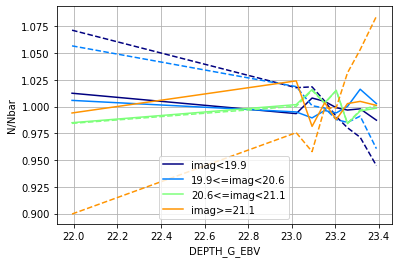

In [12]:
lbs   = {'0':'imag<%.1f'%imag_prcn[1],
         '1':'%.1f<=imag<%.1f'%(imag_prcn[1],imag_prcn[2]),
         '2':'%.1f<=imag<%.1f'%(imag_prcn[2], imag_prcn[3]),
         '3':'imag>=%.1f'%imag_prcn[3]}
colors = [plt.cm.jet(i/4) for i in range(4)]
for sid in samples.keys(): # 0,1, 2, 3
    i = int(sid)
    plt.plot(*results['MR'][sid], color=colors[i], label=lbs[sid])
    plt.plot(*results['Default'][sid], ls='--', color=colors[i])
plt.xlabel('DEPTH_G_EBV')
plt.legend()
plt.ylabel('N/Nbar')
plt.grid()

In [13]:
ibin_mid  = 0.5*(imag_prcn[1:]+imag_prcn[:-1])
ibin_err  = np.diff(imag_prcn)/2.

In [14]:
x  = []
xe = []
y  = []
ye = []
for i in params:
    print(i)
    popt, pcov = params[i]
    x.append(ibin_mid)
    xe.append(ibin_err)
    y.append(popt)
    ye.append(np.sqrt(np.diag(pcov)))
x  = np.array(x)
xe = np.array(xe)
y  = np.array(y).T
ye = np.array(ye).T

0
1
2
3


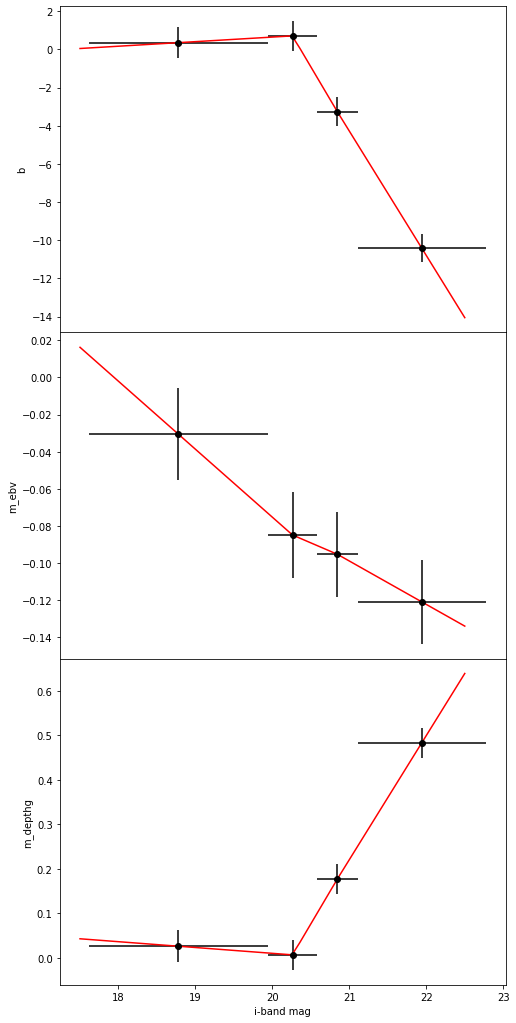

In [15]:
fig, ax = plt.subplots(nrows=3, figsize=(8, 18), sharex=True)
fig.subplots_adjust(hspace=0)
xr = np.linspace(17.5, 22.5)
ylabels = ['b', 'm_ebv', 'm_depthg']
splines = []
for i in range(3):
    #w = 1./np.power(xe[i]*xe[i] + 100*ye[i]*ye[i], 0.5)
    spl = IUS(x[i], y[i], k=1)
    splines.append(spl)
    ax[i].errorbar(x[i], y[i], yerr=ye[i], 
                   xerr=xe[i], marker='o', ls='None', c='k')
    ax[i].plot(xr, spl(xr), 'r-')
    ax[i].set(ylabel=ylabels[i])
    if i==2:ax[i].set(xlabel='i-band mag')

In [16]:
all_params = []
for spline_i in splines:
    all_params.append(spline_i(dat_imag))
all_params = np.array(all_params)

In [17]:
np.save('/home/mehdi/data/eboss/v7_1/lin_imag_params_dat.npy', all_params)

In [18]:
num_data = dat_logebv.size

In [19]:
model = []
for i in range(dat_logebv.size):
    if i % (num_data//5)==0:print(i)
    model.append(all_params[0, i] + all_params[1, i]*dat_logebv[i] + all_params[2, i]*dat_depth[i])

0
80349
160698
241047
321396


In [20]:
weights = 1./np.array(model)

In [21]:
dat['WEIGHT_SYSTOT'] = weights

In [22]:
outdata_name

'/home/mehdi/data/eboss/v7_1/0.1/eBOSS_QSO_full_NGC_v7_1.dat.fits'

In [23]:
np.percentile(weights, [0, 20, 80, 100])

array([0.65366748, 0.96916402, 1.02059652, 2.48859468])

In [24]:
import os

In [25]:
outdata_path = '/'.join(outdata_name.split('/')[:-1])
if not os.path.isdir(outdata_path):
    print('create ', outdata_path)
    os.makedirs(outdata_path)

In [26]:
ft.write(outdata_name, dat, overwrite=True)

In [27]:
ls /home/mehdi/data/eboss/v7_1/

0.1/                                    eBOSS_QSO_full_SGC_v7_1.dat.fits
eBOSS_QSO_clustering_NGC_v7_1.dat.fits  eBOSS_QSO_full_SGC_v7_1.ran.fits
eBOSS_QSO_clustering_NGC_v7_1.ran.fits  lin_imag_params_dat.npy
eBOSS_QSO_full_NGC_v7_1.dat.fits        lin_imag_params.npy
eBOSS_QSO_full_NGC_v7_1.ran.fits        results_NGC/


In [28]:
def mkcluscat(sampl,NS,ver,zmin,zmax,compmin=.5,md='dat',zfw=False,allnoz=False, diro=None):
    infile = diro+'eBOSS_'+sampl+'_full_'+NS+'_v'+ver+'.'+md+'.fits'
    if zmin == 2.2:
        sampl += 'hiz'
    wnoz = ''
    if allnoz:
        wnoz += 'allnoz_'   
        
    outfile = diro+'eBOSS_'+sampl+'_clustering_'+wnoz+NS+'_v'+ver+'.'+md+'.fits'
    print(infile)
    cat = Table.read(infile)
    if md == 'dat':
        w = ((cat['Z'] > zmin) & (cat['Z'] < zmax) & (cat['COMP_BOSS'] > compmin) & (cat['sector_SSR'] > compmin) & ((cat['IMATCH'] == 1) | (cat['IMATCH'] == 2)))
    if md == 'ran':
        #w = ((cat['Z'] > zmin) & (cat['Z'] < zmax) & (cat['COMP_BOSS'] > compmin))
        w = ((cat['COMP_BOSS'] > compmin) & (cat['sector_SSR'] > compmin))
    print(len(cat),len(cat[w]))
    ral = cat[w]['RA']
    decl = cat[w]['DEC']
    zl = cat[w]['Z']
    wfkp = cat[w]['WEIGHT_FKP']
    nz = cat[w]['NZ']
    im = cat[w]['IMATCH']
    if sampl == 'QSO' or sampl == 'QSOhiz':
        id = cat[w]['QSO_ID']
        idn = 'QSO_ID'
    if sampl == 'LRG':
        id = cat[w]['LRG_ID']
        idn = 'LRG_ID'
       
    #wz = (cat['sector_SSR'] == 0)
    #cat[wz]['sector_SSR'] = 1.
   
    #   if md == 'dat':
    ws = cat[w]['WEIGHT_SYSTOT']
    wcp = cat[w]['WEIGHT_CP']
    #       if zfm == 'SSR':
    #           wnz = 1./cat[w]['sector_SSR']
    #       if zfm == 'fibID':
    #           wnzf = doweights(cat)
    #           wnz = wnzf[w]
    #       
    #       
    #if type(zfw) != bool:
    #   wnz = zfw[w]
    #else:
    #   wnz = 1./cat[w]['sector_SSR']
    print(outfile)
    if allnoz:
        zweights = Table.read(diro+'eBOSS_'+sampl+'_nozweights_'+NS+'_v'+ver+'.'+md+'.fits')
        to = Table([ral,decl,zl,wfkp,ws,wcp,zweights[w]['WEIGHT_NOZ'],zweights[w]['WEIGHT_NOZ_ID'],zweights[w]['WEIGHT_NOZ_SSR'],nz,id],names=('RA','DEC','Z','WEIGHT_FKP','WEIGHT_SYSTOT','WEIGHT_CP','WEIGHT_NOZ','WEIGHT_NOZ_ID','WEIGHT_NOZ_SSR','NZ',idn)) 
        to.write(outfile, format='fits', overwrite=True)
    else:       
        wnz = cat[w]['WEIGHT_NOZ']
        wz = (wnz*0 != 0)
        #print(len(wnz[wz]))
        wnz[wz] = 1. #set any NaNs to 1.
        wl = (im == 2)
        wnz[wl] = 1. #legacy objects don't get a fiber weight correction
        #   if md == 'ran':
        #       ws = cat[w]['COMP_BOSS']
        #       wcp = np.ones((len(cat[w])))
        #       wnz = np.ones((len(cat[w])))   
        to = Table([ral,decl,zl,wfkp,ws,wcp,wnz,nz,id],names=('RA','DEC','Z','WEIGHT_FKP','WEIGHT_SYSTOT','WEIGHT_CP','WEIGHT_NOZ','NZ',idn)) 
        to.write(outfile, format='fits', overwrite=True)
    return True
    
    
def mkcluscat_ran(sampl,NS,ver,zmin,zmax,compmin=.5,frac = .1,dirin='',fidver='',allnoz=False, diro=None):
    # this all ensures match between data and random redshifts/weights
    # randoms have additional component to
    from random import random
    samplc = sampl
    if zmin == 2.2:
        samplc += 'hiz'
    if dirin == '':
        dirin = diro
    if fidver == '':
        fidver = ver   
    wnoz = ''
    if allnoz:
        wnoz += 'allnoz_'   
    
    datfile = diro+'eBOSS_'+samplc+'_clustering_'+wnoz+NS+'_v'+ver+'.dat.fits'
    print(datfile)
    dat = ft.read(datfile)
    dz = dat['Z']
    dw = dat['WEIGHT_SYSTOT']
    dcp = dat['WEIGHT_CP']
    dzf = dat['WEIGHT_NOZ']
    if allnoz:
        dzif = dat['WEIGHT_NOZ_ID']
        dzsf = dat['WEIGHT_NOZ_SSR']
    dfkp = dat['WEIGHT_FKP']
    dnz = dat['NZ']
    #infile = dirin+'eBOSS_'+sampl+'_full_'+NS+'_v'+fidver+'.ran.fits'
    infile = diro+'eBOSS_'+sampl+'_full_'+NS+'_v'+fidver+'.ran.fits'
    outfile = diro+'eBOSS_'+samplc+'_clustering_'+wnoz+NS+'_v'+ver+'.ran.fits'
    print(infile, outfile)
    cat = ft.read(infile)
    w = ((cat['COMP_BOSS'] > compmin) & (cat['sector_SSR'] > compmin) & (cat['Z'] > zmin) & (cat['Z'] < zmax))
    print(len(cat),len(cat[w]))
    ralf = cat[w]['RA']
    declf = cat[w]['DEC']
    wslf = cat[w]['COMP_BOSS']
    ral  = []
    decl = []
    zl = []
    wsl = []
    cpl = []
    zfl = []
    if allnoz:
        zfil = []
        zfsl = []
    nzl = []
    fkpl = []
    ndat = len(dz)
    for i in range(0,len(ralf)):
        ran = random()
        if ran < frac:
            ral.append(ralf[i])
            decl.append(declf[i])
            sb = wslf[i]
            zind = int(ndat*random())
            zl.append(dz[zind])
            wsl.append(sb*dw[zind])
            cpl.append(dcp[zind])
            zfl.append(dzf[zind])
            nzl.append(dnz[zind])
            fkpl.append(dfkp[zind])
            if allnoz:
                zfil.append(dzif[zind])
                zfsl.append(dzsf[zind]) 
    print(len(ral))
    ral  = np.array(ral)
    decl = np.array(decl)
    zl = np.array(zl)
    wsl = np.array(wsl)
    cpl = np.array(cpl)
    zfl = np.array(zfl)
    nzl = np.array(nzl)
    fkpl = np.array(fkpl)
    if allnoz:
        zfil = np.array(zfil)
        zfsl = np.array(zfsl)
        to = Table([ral,decl,zl,fkpl,wsl,cpl,zfl,zfil,zfsl,nzl],names=('RA','DEC','Z','WEIGHT_FKP','WEIGHT_SYSTOT','WEIGHT_CP','WEIGHT_NOZ','WEIGHT_NOZ_ID','WEIGHT_NOZ_SSR','NZ'))   
        to.write(outfile, format='fits', overwrite=True)
    else:               
        to = Table([ral,decl,zl,fkpl,wsl,cpl,zfl,nzl],names=('RA','DEC','Z','WEIGHT_FKP','WEIGHT_SYSTOT','WEIGHT_CP','WEIGHT_NOZ','NZ'))   
        to.write(outfile, format='fits', overwrite=True)
    return True

In [29]:
mkcluscat('QSO', hemi,version,zmin,zmax,compmin,md='dat', diro=patho)
frac = 0.5 #degree of sub-sampling on randoms
mkcluscat_ran('QSO',hemi,version,zmin,zmax,compmin,frac=frac, diro=patho)
#mkcluscat('QSO',hemi,ver,zmax,hizmax,compmin,md='dat')
#frac = 0.5 #degree of sub-sampling on randoms
#mkcluscat_ran('QSO',hemi,ver,zmax,hizmax,compmin,frac=frac)


#calczfweights_all('QSO',hemi,ver,zmin,zmax,compmin)
#mkcluscat('QSO',hemi,ver,zmin,zmax,compmin,md='dat',allnoz=True)
#frac = 0.5 #degree of sub-sampling on randoms
#mkcluscat_ran('QSO',hemi,ver,zmin,zmax,compmin,frac=frac,allnoz=True)

/home/mehdi/data/eboss/v7_1/0.1/eBOSS_QSO_full_NGC_v7_1.dat.fits


401745 218202
/home/mehdi/data/eboss/v7_1/0.1/eBOSS_QSO_clustering_NGC_v7_1.dat.fits
/home/mehdi/data/eboss/v7_1/0.1/eBOSS_QSO_clustering_NGC_v7_1.dat.fits
/home/mehdi/data/eboss/v7_1/0.1/eBOSS_QSO_full_NGC_v7_1.ran.fits /home/mehdi/data/eboss/v7_1/0.1/eBOSS_QSO_clustering_NGC_v7_1.ran.fits
17233374 11096305
5544949


True

In [30]:
path

'/home/mehdi/data/eboss/v7_1/'

In [31]:
mkcluscat('QSO', hemi,version,zmin,zmax,compmin,md='dat', diro=path)
frac = 0.5 #degree of sub-sampling on randoms
mkcluscat_ran('QSO',hemi,version,zmin,zmax,compmin,frac=frac, diro=path)
#mkcluscat('QSO',hemi,ver,zmax,hizmax,compmin,md='dat')
#frac = 0.5 #degree of sub-sampling on randoms
#mkcluscat_ran('QSO',hemi,ver,zmax,hizmax,compmin,frac=frac)


#calczfweights_all('QSO',hemi,ver,zmin,zmax,compmin)
#mkcluscat('QSO',hemi,ver,zmin,zmax,compmin,md='dat',allnoz=True)
#frac = 0.5 #degree of sub-sampling on randoms
#mkcluscat_ran('QSO',hemi,ver,zmin,zmax,compmin,frac=frac,allnoz=True)

/home/mehdi/data/eboss/v7_1/eBOSS_QSO_full_NGC_v7_1.dat.fits
401745 218202
/home/mehdi/data/eboss/v7_1/eBOSS_QSO_clustering_NGC_v7_1.dat.fits
/home/mehdi/data/eboss/v7_1/eBOSS_QSO_clustering_NGC_v7_1.dat.fits
/home/mehdi/data/eboss/v7_1/eBOSS_QSO_full_NGC_v7_1.ran.fits /home/mehdi/data/eboss/v7_1/eBOSS_QSO_clustering_NGC_v7_1.ran.fits
17233374 11096305
5547590


True